In [53]:
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [54]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)


In [55]:
class Timer:  # @save
    """Record multiple running times."""
    
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()


In [56]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.08836 sec'

In [57]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'


'0.00000 sec'

In [58]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

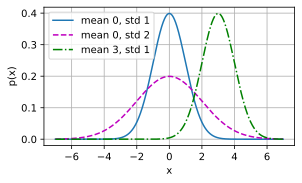

In [59]:
# Use numpy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]

d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], 
         xlabel='x', ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])


# 3.2 Linear Regression Implementation from Scratch


In [60]:
import random
import torch
from d2l import torch as d2l

In [61]:
def synthetic_data(w, b, num_examples):  # @save
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))


In [62]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)


In [63]:
print('features:', features[0],'\nlabel:', labels[0])


features: tensor([ 0.9513, -1.3734]) 
label: tensor([10.7839])


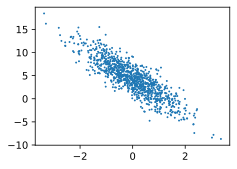

In [64]:
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

### 3.2.2 Reading the Dataset

In [65]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]


In [66]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break


tensor([[ 0.9566,  0.0057],
        [ 0.2720,  0.3229],
        [ 1.0244,  1.0379],
        [ 0.0283, -1.2413],
        [ 0.9466,  0.2184],
        [-0.5015, -0.2535],
        [-0.1935, -0.7249],
        [-2.4923,  0.3670],
        [ 0.5738,  0.9496],
        [ 0.6136, -0.0975]]) 
 tensor([[ 6.0921],
        [ 3.6414],
        [ 2.7215],
        [ 8.4849],
        [ 5.3389],
        [ 4.0694],
        [ 6.2933],
        [-2.0291],
        [ 2.0988],
        [ 5.7585]])


### 3.2.3 Initializing Model Parameters


Before we can begin optimizing our modelʼs parameters by minibatch stochastic gradient descent,
we need to have some parameters in the first place. In the following code, we initialize weights
by sampling random numbers from a normal distribution with mean 0 and a standard deviation
of 0.01, and setting the bias to 0.


In [67]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)


### 3.2.4 Defining the Model


In [68]:
def linreg(X, w, b): #@save
    """The linear regression model."""
    return torch.matmul(X, w) + b


### 3.2.5 Defining the Loss Function

In [69]:
def squared_loss(y_hat, y): #@save
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 3.2.6 Defining the Optimization Algorithm

In [70]:
def sgd(params, lr, batch_size): #@save
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 3.2.7 Training